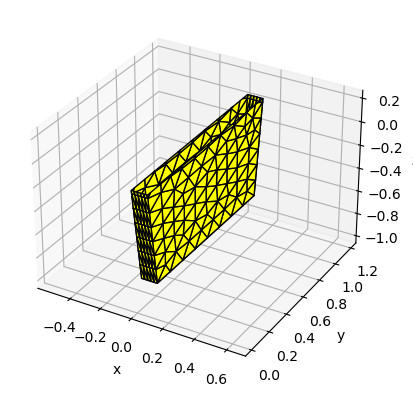

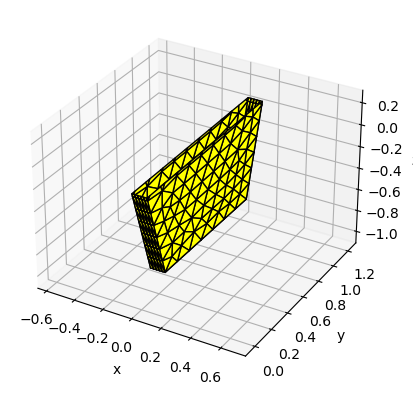

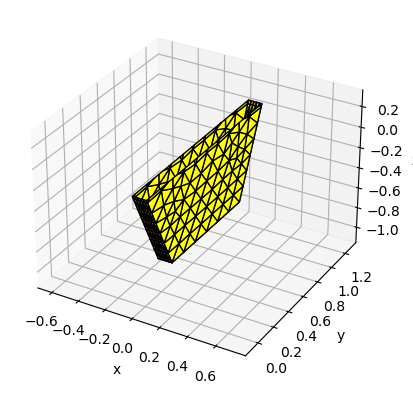

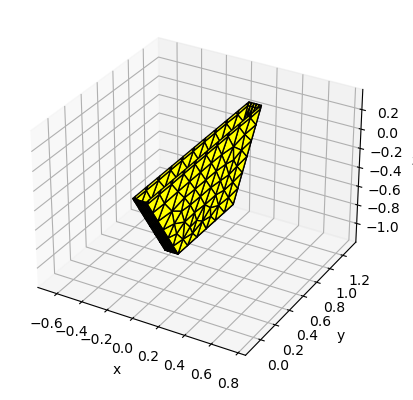

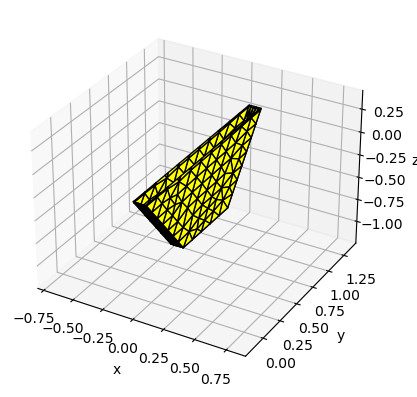

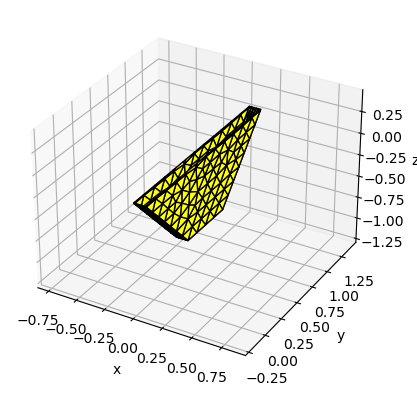

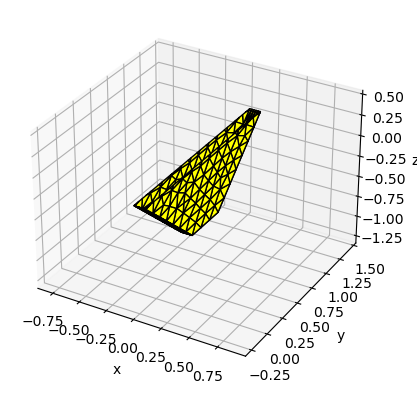

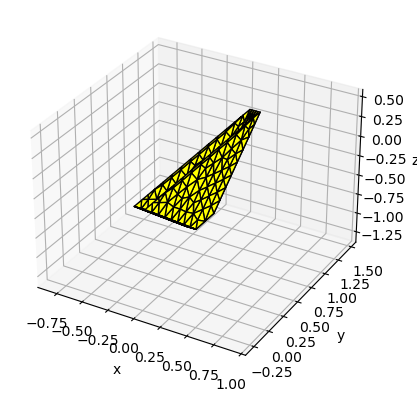

Mesh dimensions:
  x-range: 0.0 to 0.1 (size: 0.1)
  y-range: -0.45 to 1.65 (size: 2.1)


In [33]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute
import wecopttool as wot
import pygmsh

# Mesh 
# Define the base coordinates and the changes to apply
base_y_top = 1.2
base_y_bottom = 0.0
changes = [0.05      , 0.10714286, 0.16428571, 0.22142857, 0.27857143,
       0.33571429, 0.39285714, 0.45      ]  # Define the increments for each new geometry
for change in changes:
    with pygmsh.geo.Geometry() as geom:
        poly = geom.add_polygon(
            [
                [0.1, base_y_bottom + change, -0.8],
                [0.1, base_y_top - change, -0.8],
                [0.1, base_y_top + change, 0.1],
                [0.1, base_y_bottom - change, 0.1],
            ],
            mesh_size=0.15,
        )
        geom.extrude(poly, [-0.2, 0.0, 0], num_layers=5)
        mesh = geom.generate_mesh()
        oswec_flap = cpy.FloatingBody.from_meshio(mesh, name='flap').keep_immersed_part()
        oswec_flap.add_rotation_dof(name='Pitch')
        oswec_flap.rotation_center = np.array([0, 0, -0.57])
        oswec_flap.show_matplotlib()
# Extract the points array from the mesh
points = mesh.points

# Determine the minimum and maximum coordinates along each axis
min_x, max_x = points[:, 0].min(), points[:, 0].max()
min_y, max_y = points[:, 1].min(), points[:, 1].max()
min_z, max_z = points[:, 2].min(), points[:, 2].max()

# Print the dimensions of the mesh
print(f"Mesh dimensions:")
print(f"  x-range: {min_x} to {max_x} (size: {max_x - min_x})")
print(f"  y-range: {min_y} to {max_y} (size: {max_y - min_y})")


In [3]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute
import wecopttool as wot
import pygmsh
import xarray as xr
import pandas as pd
all_data = [] # List to hold iteration data

# Mesh 
# Define the base coordinates and the changes to apply
base_y_top = 1.2
base_y_bottom = 0.0
changes = [0.05, 0.1, 0.2]  # Define the increments for each new geometry
for change in changes:
    with pygmsh.geo.Geometry() as geom:
        poly = geom.add_polygon(
            [
                [0.1, base_y_bottom + change, -0.8],
                [0.1, base_y_top - change, -0.8],
                [0.1, base_y_top + change, 0.1],
                [0.1, base_y_bottom - change, 0.1],
            ],
            mesh_size=0.15,
        )
        geom.extrude(poly, [-0.1, 0.0, 0], num_layers=5)
        mesh = geom.generate_mesh()
        oswec_flap = cpy.FloatingBody.from_meshio(mesh, name='flap').keep_immersed_part()
        oswec_flap.add_rotation_dof(name='Pitch')
        oswec_flap.rotation_center = np.array([0, 0, -0.57])
        ndof = oswec_flap.nb_dofs

        #Frequency Definition
        
        f1 = 0.3  # in Hz
        nfreq = 10
        freq = wot.frequency(f1, nfreq, False)  # False -> no zero frequency

        #BEM Solver
        
        bem_data = wot.run_bem(oswec_flap, freq, depth=0.7)

        #PTO Definition
        omega = bem_data.omega.values
        gear_ratio = 12.0
        torque_constant = 6.7
        winding_resistance = 0.5
        winding_inductance = 0.0
        drivetrain_inertia = 2.0
        drivetrain_friction = 1.0
        drivetrain_stiffness = 0.0
    
        drivetrain_impedance = (1j*omega*drivetrain_inertia +
                                drivetrain_friction +
                                1/(1j*omega)*drivetrain_stiffness)
    
        winding_impedance = winding_resistance + 1j*omega*winding_inductance
    
    
        pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
        off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
        pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape)
        pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
        pto_impedance_22 = winding_impedance
        pto_impedance_3 = np.array([[pto_impedance_11, pto_impedance_12],
                                [pto_impedance_21, pto_impedance_22]])
        name = ["PTO_Pitch"]
        kinematics = np.eye(ndof)
        controller = None
        loss = None
        pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance_3, loss, name)

        # PTO dynamics forcing function
        f_add = {'PTO': pto.force_on_wec}
        # Constraint
        f_max = 400.0  # PTO Force
        nsubsteps = 4
        def const_f_pto(wec, x_wec, x_opt, waves):  # Format for scipy.optimize.minimize
            f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
            return f_max - np.abs(f.flatten())

        ineq_cons = {'type': 'ineq',
                     'fun': const_f_pto,
                     }
        constraints = [ineq_cons]

        #WEC Creation
        
        wec = wot.WEC.from_bem(
            bem_data,
            constraints=constraints,
            friction=None,
            f_add=f_add,
        )
        #Wave Definition
        
        amplitude = 0.0625
        wavefreq = 0.6  # Hz
        phase = 30
        wavedir = 0
        waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

        #Objective Function
        obj_fun = pto.mechanical_average_power
        nstate_opt = 2 * nfreq

        options = {'maxiter': 200}
        scale_x_wec = 1e1
        scale_x_opt = 1e-1
        scale_obj = 1e-2

        results = wec.solve(
            waves,
            obj_fun,
            nstate_opt,
            optim_options=options,
            scale_x_wec=scale_x_wec,
            scale_x_opt=scale_x_opt,
            scale_obj=scale_obj,
        )
            # Post-process results
        pto_fdom, pto_tdom = pto.post_process(wec, results[0], waves.sel(realization=0), nsubsteps=nsubsteps)
        wec_fdom, wec_tdom = wec.post_process(results[0], waves.sel(realization=0), nsubsteps=nsubsteps)
        iteration_data = {
            'opt_mechanical_average_power': results[0].fun,
            'pto_fdom': pto_fdom,
            'pto_tdom': pto_tdom,
            'wec_fdom': wec_fdom,
            'wec_tdom': wec_tdom,
            'change': change
        }
        all_data.append(iteration_data)
        
        opt_mechanical_average_power = results[0].fun
        print(f'Optimal average mechanical power: {opt_mechanical_average_power} W')
df = pd.DataFrame(all_data)

Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
The resolution of the mesh 'flap' of the body 'flap_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 9.48e-02 > λ/8.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
The resolution of the mesh 'flap' of the body 'flap_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears be

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3631093573936356
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28


Optimal average mechanical power: -36.31093573936356 W


Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
The resolution of the mesh 'flap' of the body 'flap_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.00e-01 > λ/8.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
The resolution of the mesh 'flap' of the body 'flap_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears be

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.35101466219893035
            Iterations: 25
            Function evaluations: 25
            Gradient evaluations: 25


Optimal average mechanical power: -35.101466219893034 W


Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
The resolution of the mesh 'flap' of the body 'flap_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.03e-01 > λ/8.
Check the position of the free_surface and the water_depth
or use body.keep_immersed_part() to clip the mesh.
The resolution of the mesh 'flap' of the body 'flap_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears be

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.037476472745916915
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimal average mechanical power: -3.7476472745916913 W


In [41]:
def design_obj_fun(changes):
    change = changes[0]
    with pygmsh.geo.Geometry() as geom:
        poly = geom.add_polygon(
            [
                [0.1, base_y_bottom + change, -0.8],
                [0.1, base_y_top - change, -0.8],
                [0.1, base_y_top + change, 0.1],
                [0.1, base_y_bottom - change, 0.1],
            ],
            mesh_size=0.15,
        )
        geom.extrude(poly, [-0.1, 0.0, 0], num_layers=5)
        mesh = geom.generate_mesh()
        oswec_flap = cpy.FloatingBody.from_meshio(mesh, name='flap').keep_immersed_part()
        oswec_flap.add_rotation_dof(name='Pitch')
        oswec_flap.rotation_center = np.array([0, 0, -0.57])
        ndof = oswec_flap.nb_dofs

        #Frequency Definition
        
        f1 = 0.3  # in Hz
        nfreq = 50
        freq = wot.frequency(f1, nfreq, False)  # False -> no zero frequency

        #BEM Solver
        
        bem_data = wot.run_bem(oswec_flap, freq, depth=0.7)

        #PTO Definition
        omega = bem_data.omega.values
        gear_ratio = 12.0
        torque_constant = 6.7
        winding_resistance = 0.5
        winding_inductance = 0.0
        drivetrain_inertia = 2.0
        drivetrain_friction = 1.0
        drivetrain_stiffness = 0.0
    
        drivetrain_impedance = (1j*omega*drivetrain_inertia +
                                drivetrain_friction +
                                1/(1j*omega)*drivetrain_stiffness)
    
        winding_impedance = winding_resistance + 1j*omega*winding_inductance
    
    
        pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
        off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
        pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape)
        pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
        pto_impedance_22 = winding_impedance
        pto_impedance_3 = np.array([[pto_impedance_11, pto_impedance_12],
                                [pto_impedance_21, pto_impedance_22]])
        name = ["PTO_Pitch"]
        kinematics = np.eye(ndof)
        controller = None
        loss = None
        pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance_3, loss, name)

        # PTO dynamics forcing function
        f_add = {'PTO': pto.force_on_wec}
        # Constraint
        f_max = 400.0  # PTO Force
        nsubsteps = 4
        def const_f_pto(wec, x_wec, x_opt, waves):  # Format for scipy.optimize.minimize
            f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
            return f_max - np.abs(f.flatten())

        ineq_cons = {'type': 'ineq',
                     'fun': const_f_pto,
                     }
        constraints = [ineq_cons]

        #WEC Creation
        
        wec = wot.WEC.from_bem(
            bem_data,
            constraints=constraints,
            friction=None,
            f_add=f_add,
        )
        #Wave Definition
        
        amplitude = 0.0625
        wavefreq = 0.6  # Hz
        phase = 30
        wavedir = 0
        waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

        #Objective Function
        obj_fun = pto.mechanical_average_power
        nstate_opt = 2 * nfreq

        options = {'maxiter': 200}
        scale_x_wec = 1e1
        scale_x_opt = 1e-1
        scale_obj = 1e-2

        results = wec.solve(
            waves,
            obj_fun,
            nstate_opt,
            optim_options=options,
            scale_x_wec=scale_x_wec,
            scale_x_opt=scale_x_opt,
            scale_obj=scale_obj,
        )       
        opt_mechanical_average_power = results[0].fun
        print(f'Optimal average mechanical power: {opt_mechanical_average_power} W')
        return results[0].fun

In [35]:
changes = [0.05, 0.1, 0.2,0.3,0.4]  # Define the increments for each new geometry

In [42]:
wot.set_loglevel("error")  # Suppress warnings

# range over which to search
ranges = (slice(changes[0], changes[-1]+np.diff(changes)[0], np.diff(changes)[0]),)

# solve
opt_x0, opt_fval, x0s, fvals = brute(func=design_obj_fun, ranges=ranges, full_output=True,  finish=None)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.36313547080292746
            Iterations: 121
            Function evaluations: 121
            Gradient evaluations: 121
Optimal average mechanical power: -36.31354708029274 W
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.35103484681694247
            Iterations: 117
            Function evaluations: 118
            Gradient evaluations: 117
Optimal average mechanical power: -35.10348468169425 W
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2603700988094849
            Iterations: 97
            Function evaluations: 97
            Gradient evaluations: 97
Optimal average mechanical power: -26.037009880948492 W
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.03736986292696328
            Iterations: 107
            Function evaluations: 107
            Grad

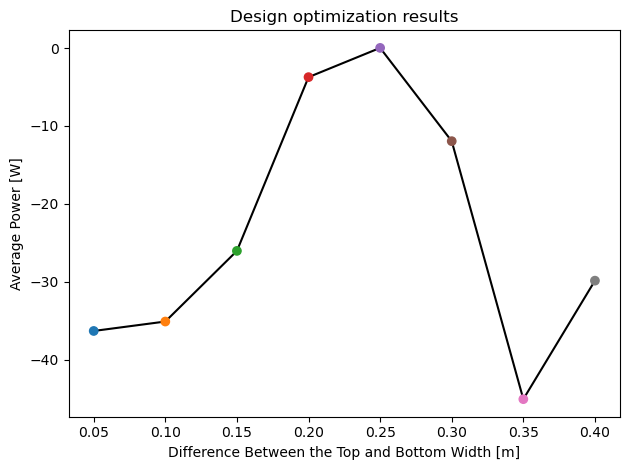

In [43]:
fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(x0s)]
ax.plot(x0s, fvals, 'k', zorder=0)
ax.scatter(x0s, fvals, c=colors, zorder=1)

ax.set_xlabel('Difference Between the Top and Bottom Width [m]')
ax.set_ylabel('Average Power [W]')
ax.set_title('Design optimization results')
fig.tight_layout()

In [29]:
ranges = (slice(changes[0], changes[-1]+np.diff(changes)[0], np.diff(changes)[0]))
ranges

slice(0.05, 0.45, 0.05)

In [30]:
(0.45-0.05)/0.05

8.0

In [32]:
r2_vals = np.linspace(0.05, 0.45, 8, endpoint=True)
r2_vals

array([0.05      , 0.10714286, 0.16428571, 0.22142857, 0.27857143,
       0.33571429, 0.39285714, 0.45      ])